## **데이터셋 불러오기**

TorchVision에서 Fashion-MNIST 데이터셋 불러오기

**Fashion-MNIST**
- Zalando의 기사 이미지 데이터셋
- 60,000개의 Train 데이터
- 10,000의 Test 데이터
- 흑백의 28 * 28 이미지
- 10개의 class 중 정답 label 1개



`root`: Train/Test 데이터가 저장되는 경로

`train`: 학습용/테스트용 데이터셋 여부 지정

`download=True`는 `root` 디렉토리에 데이터가 없는 경우 인터넷에서 다운로드함

`transform`과 `target_transform`은 feature과 정답 label의 변형(transform)을 지정함

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
	root="data",
	train = True,
	download=True,
	transform = ToTensor()
)

test_data = datasets.FashionMNIST(
	root="data",
	train = False,
	download=True,
	transform = ToTensor()
)

In [2]:
print(len(training_data))
print(len(test_data))

60000
10000


In [3]:
# 0~train_data-1까지 중에서 random한 1개값을 포함하는 tensor를 받아서 python 숫자로 변환
# 0~59999
sample_idx = torch.randint(len(training_data), size=(1,)).item()
print(sample_idx)

sample_idx2 = torch.randint(len(training_data), size=(2,4))
print(sample_idx2)

22441
tensor([[27090,  8609, 13221, 10458],
        [42145, 33914,  9983,  3337]])


In [4]:
training_sample = training_data[sample_idx]
# print(type(training_sample))	# tuple
# print(training_sample)	# (img, label)
# print(training_sample[0])	# img의 tensor 배열
print(training_sample[1])
print(training_sample[0].shape)

8
torch.Size([1, 28, 28])


## **데이터셋 순회하고 시각화하기**

`Dataset`에 list처럼 직접 접근(index)할 수 있다.

`training_data[index]`, `matplotlib`를 사용하여 학습 데이터의 일부를 시각화해보기

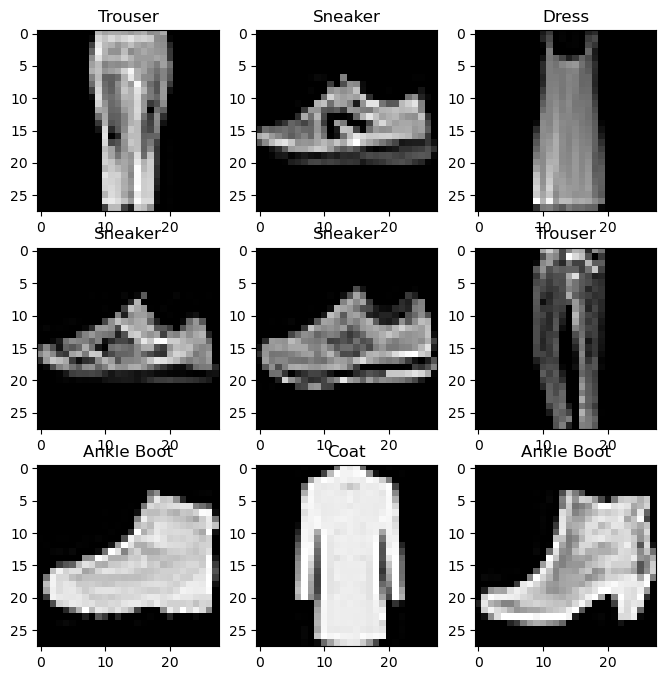

In [5]:
# class 종류
labels_map = {
	0: "T-shirt",
	1: "Trouser",
	2: "Pullover",
	3: "Dress",
	4: "Coat",
	5: "Sandal",
	6: "Shirt",
	7: "Sneaker",
	8: "Bag",
	9: "Ankle Boot"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	
	figure.add_subplot(rows, cols, i)
	plt.title(labels_map[label])
	# plt.axis("off")	# 가로축, 세로축 제거
	plt.imshow(img.squeeze(), cmap="gray")	# squeeze: (1,28,28)을 (28,28)로 변환

plt.show()

## **파일에서 사용자 정의 데이터셋 만들기**

사용자 정의 Dataset class는 반드시 3개 함수를 구현해야 한다.

- `__init__`
	- Dataset 객체가 생성될 때 1번만 실행됨
	- 이미지와 주석 파일(annotation_file)이 포함된 디텍토리와 2가지 tranform 초기화
- `__len__`
	- 데이터셋의 샘플 개수를 반환
- `__getitem__`
	- 주어진 index에 해당하는 샘플을 데이터셋에서 불러오고 반환
	- index를 기반으로 디스크에서 이미지 위치를 식별
	- `read_image`를 사용해서 이미지를 tensor로 변환
	- `self.img_labels`의 csv 데이터로부터 해당하는 정답 label을 가져오고, transform 함수들을 호출한 뒤, tensor 이미지와 label을 dictionary 형으로 반환

FashionMNIST 이미지들은 `img_dir` 디렉토리에 저장되고, 정답은 `annotations_file` csv 파일에 별도로 저장됨




[labels.csv]
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):	# Dataset 상속 받음
	def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
		self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])	# 파일 이름 & label
		self.img_dir = img_dir
		self.transform = transform
		self.target_transform = target_transform
	
	def __len__(self):
		return len(self.img_labels)
	
	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
		image = read_image(img_path)
		label = self.img_labels.iloc[idx, 1]
		
		if self.transform:
			image = self.transform(image)
		if self.target_transform:
			label = self.target_transform(label)
		
		return image, label

# **DataLoader로 학습용 데이터 준비하기**

- `Dataset`은 **데이터셋의 feature을 가져오고, 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 함**
- 모델을 학습할 때, 보통
    - 샘플들을 **미니배치(minibatch)**로 전달
    - **매 epoch마다 데이터를 다시 섞어서** 과적합 막음
- Python의 `multiprocessing`을 사용해서 **데이터 검색 속도를 높이려고** 함

- `DataLoader`
    - 위의 복잡한 과정들을 간단한 API로 추상화한 순회 가능한 **객체**(iterable)

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [9]:
print(train_dataloader)

In [10]:
print(len(train_dataloader))

938


In [11]:
print(64*938)

60032


# **DataLoader를 통해 순회하기(Iterate)**

- DataLoader에 데이터셋을 불러온 뒤, 데이터셋을 순회(iterate)할 수 있음
- 데이터를 한 batch씩 가져옴
    - dataloader만큼 순회하면 1 epoch 순회한거임!
        
        ```python
        print(len(train_dataloader))  # 938
        print(64 * 938)        # 60032   
        ```
        
- 매 순회마다, 한 batch(여기서는 `batch_size=64`)에 해당하는 `train_features`와 `train_labels`을 반환
- `shuffle=True`로 하면, 모든 batch를 순회한 뒤 데이터가 섞임

- `iter(train_dataloader)`: `train_dataloader`의 **반복자(iterator) 생성**. 반복자는 데이터셋을 한 번에 하나씩 순회할 수 있도록 함
- `next(iter())`: 반복자의 현재 위치의 **다음 값 가져옴**.
    - 데이터셋의 끝에 도달하면 `StopIteration` 예외 발생시킴

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: (tensor(7), 'Sneaker')


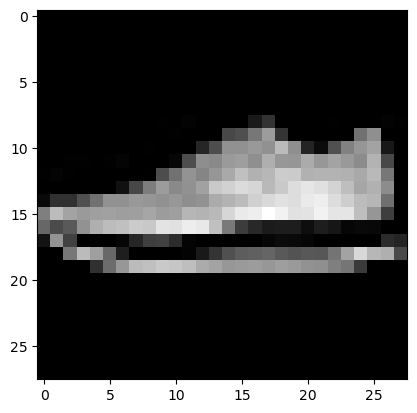

In [12]:
# 이미지와 정답(label) 표시
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()	# (1, 28, 28) -> (28, 28)
label = train_labels[0]

print(f"Label: {label, labels_map[label.item()]}")

plt.imshow(img, cmap="gray")
plt.show()

In [13]:
print(type(label))

<class 'torch.Tensor'>
